In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
import imageio
import numpy as np
import os
torch.manual_seed(2024)

data_dir = '/data/'
assets_dir = '/assets/'

img_dir = assets_dir + "/images"
gif_dir = assets_dir + "/gifs"
os.makedirs(img_dir, exist_ok=True)
os.makedirs(gif_dir, exist_ok=True)


## weighted context of tokens

In [2]:
'''

Self attention -----> away for tokens to interact with each other in a sequence. 

Lets say we have a batch (B) of sequences, with each context lentgh or block size (B) of tokens, and each token has a dimension of features, or lets call them channels (C).

B,T,C 

Lets say, ith token in T, wants to know the relationship with all other tokens in T (including itself), one naive way is to take the mean of all channel infrmation of all tokens in T, 
such a way that the information propagates from the 0 to i-1 -> ith token. This summerize the context to current token with context of all other tokens in T in the past.

This is a extreamly simple way to do it, but it is not enough, because it is not considering the relationship between the tokens in the context, but lets worry about it later.


'''

B,T,C = 4,8,2 # batch, tokens, channels
x = torch.randn(B,T,C)
print(x.shape)

torch.Size([4, 8, 2])


In [3]:
# x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(x.size(0)):
    for t in range(x.size(1)):
        prev = x[b,:t+1]
        xbow[b,t] = torch.mean(prev, dim=0)

In [4]:
x[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])

In [5]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [6]:
B, T, C = 8, 8, 2
x = torch.randn(B, T, C)
xbow = torch.zeros((B, T, C))


def plot_frame(x, xbow, b, t, frame_number, save_dir, vmin, vmax):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    axes = ax.flatten()

    
    axes[0].set_title(f'Original Data (b={b}, t={t})')
    cax0 = axes[0].imshow(x[b].detach().numpy().T, aspect='auto', cmap='rainbow', vmin=vmin, vmax=vmax)
    fig.colorbar(cax0, ax=axes[0])
    for i in range(x.size(1)):
        for j in range(x.size(2)):
            axes[0].text(i, j, f'{x[b, i, j]:.2f}', ha='center', va='center', color='white' if x[b, i, j] < 0 else 'black')

    
    axes[1].set_title(f'Attention Result (b={b}, t={t})')
    cax1 = axes[1].imshow(xbow[b].detach().numpy().T, aspect='auto', cmap='rainbow', vmin=vmin, vmax=vmax)
    fig.colorbar(cax1, ax=axes[1])
    for i in range(x.size(1)):
        for j in range(x.size(2)):
            axes[1].text(i, j, f'{xbow[b, i, j]:.2f}', ha='center', va='center', color='white' if xbow[b, i, j] < 0 else 'black')

    fig.tight_layout()
    fig.savefig(f"{save_dir}/frame_{frame_number}.png")
    plt.close(fig)

    for ax in axes:
        ax.set_yticks(range(x.size(2)))
        ax.set_yticklabels([f'{i}' for i in range(x.size(2))], fontsize=12, va='center', fontweight='bold', fontfamily='serif')
        ax.set_xticks(range(x.size(1)))
        for s in ['top', 'bottom', 'left', 'right']:
            ax.spines[s].set_visible(False)


vmin, vmax = -1, 1
frame_number = 0
for b in range(x.size(0)):
    for t in range(x.size(1)):
        prev = x[b, :t+1]
        xbow[b, t] = torch.mean(prev, dim=0)
        plot_frame(x, xbow, b, t, frame_number, save_dir=img_dir, vmin=vmin, vmax=vmax)
        frame_number += 1

with imageio.get_writer(f"{gif_dir}/attention.gif", mode='I', duration=0.1) as writer:
    for i in range(frame_number):
        image = imageio.imread(f"{img_dir}/frame_{i}.png")
        writer.append_data(image)
        os.remove(f"{img_dir}/frame_{i}.png")


/tmp/ipykernel_236857/2264517232.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f"{img_dir}/frame_{i}.png")


In [ ]:
torch.manual_seed(1337)
a = torch.ones(3,3)
x = torch.tril((torch.ones(3,3)))
x = x / torch.sum(x, dim=1, keepdim=True) # for mean calculation
b = torch.randint(0,10,(3,2)).float()
print('*'*10)
print(a)
print('*'*10)
print(x)
print('*'*10)
print(b)
print('*'*10)
c = x @ b
print(c)

**********
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
**********
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
**********
tensor([[5., 7.],
        [2., 0.],
        [5., 3.]])
**********
tensor([[5.0000, 7.0000],
        [3.5000, 3.5000],
        [4.0000, 3.3333]])


 here x is mimicing the for loop from 0 to ith element, and when mulitply with b were are ending up at the sum of all the 0 to ith T steps. This being repeated in all the channels in the T

 

In [45]:
# version 1
B,T,C = 4,8,2 # batch, tokens, channels
x = torch.randn(B,T,C)
print(x.shape)

xbow = torch.zeros((B,T,C))
for b in range(x.size(0)):
    for t in range(x.size(1)):
        prev = x[b,:t+1]
        xbow[b,t] = torch.mean(prev, dim=0)

torch.Size([4, 8, 2])


In [46]:
# version 2
# print(x)
wei = torch.tril(torch.ones(T,T))
# print(wei)
wei = wei / torch.sum(wei,dim = 1, keepdim = True) 
print(wei.shape)
# print(wei)
xbow1 = wei @ x # (B*,T,T) @ (B,T,C) = (B,T,C) -----> pytorch added the B* dimension automatically to do the batch matrix multiplication
print(xbow.shape)
# print(xbow1)

torch.Size([8, 8])
torch.Size([4, 8, 2])


In [47]:
torch.allclose(xbow,xbow1)

True

In [48]:
xbow[0], xbow1[0]

(tensor([[-0.1244, -1.6824],
         [ 0.5051, -0.8824],
         [ 0.4332, -0.3097],
         [ 0.2636, -0.1644],
         [ 0.3596,  0.0460],
         [ 0.2451,  0.0514],
         [ 0.1557,  0.0980],
         [ 0.1502,  0.3750]]),
 tensor([[-0.1244, -1.6824],
         [ 0.5051, -0.8824],
         [ 0.4332, -0.3097],
         [ 0.2636, -0.1644],
         [ 0.3596,  0.0460],
         [ 0.2451,  0.0514],
         [ 0.1557,  0.0980],
         [ 0.1502,  0.3750]]))

In [52]:
# version 3
tril = torch.tril(torch.ones(T,T))
wei = torch.zeros((T,T)) # (T,T) ---> this could be a context impotance of with respect to each token in the sequence
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim = 1)
xbow2 = wei @ x # (B*,T,T) @ (B,T,C) = (B,T,C) -----> pytorch added the B* dimension automatically to do the batch matrix multiplication
torch.allclose(xbow,xbow2)


True

## self attention

Instead of constant weights (torch.zeros(T,T)) for every element, we weill create a data dependet wei that create the importance in the context.

In [16]:
# version 4 self attention

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.rand((B,T,C))

head_size = 16
num_heads = C // head_size # -->> 


query = nn.Linear(C,head_size,bias= False) # (C,head_size)
key = nn.Linear(C,head_size,bias = False) #(C,head_size)
value = nn.Linear(C,head_size,bias = False) #(C,head_size)

# query -- what I am interested in
# key --  here is what i have
# value --- if you find me interesting, here is what i will communicate to you.

k = key(x) ##--> (B,T,head_size)
q = query(x) ##--> (B,T,head_size)

# wei = q @ k.transpose(-2,-1) # (B,T,h) @ (B,h,T) - > (B,T,T)
wei = q @ k.transpose(-2,-1) / head_size ** 0.5 # (B,T,h) @ (B,h,T) - > (B,T,T)
tril = torch.tril(torch.ones(T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim = 1)

v = value(x) # (B,T,h)
out = wei @ v # (B,T,T) @ (B,T,h) = (B,T,h)

print(out.shape)
print(out[0])


torch.Size([4, 8, 16])
tensor([[ 2.4370e-02, -4.6804e-02,  2.1306e-02,  1.9785e-02, -4.4058e-02,
         -2.0566e-02, -4.8582e-02, -6.0435e-02,  9.3066e-03, -3.5572e-02,
          3.1700e-03, -7.0882e-02, -1.0409e-02,  7.9979e-02, -4.0685e-02,
          7.0287e-02],
        [ 7.0397e-02, -2.3965e-02,  6.1038e-02,  8.7629e-03, -1.0016e-01,
          1.6956e-02, -7.2780e-02, -1.3956e-01, -8.8686e-03, -1.0096e-01,
         -2.3039e-02, -1.5474e-01, -4.8996e-02,  1.4571e-01, -3.8007e-02,
          1.0644e-01],
        [ 8.3102e-02, -4.0897e-02,  1.4576e-01,  1.6216e-03, -1.7968e-01,
          6.0904e-03, -1.3988e-01, -2.4223e-01, -1.3425e-02, -1.4724e-01,
          2.4387e-02, -2.3852e-01, -7.5729e-02,  1.9417e-01, -3.2575e-02,
          1.0631e-01],
        [ 7.1802e-02, -1.0585e-02,  2.3597e-01, -1.9714e-02, -3.2637e-01,
          1.2479e-02, -2.3087e-01, -3.3177e-01, -2.4223e-02, -2.3058e-01,
          8.2523e-02, -3.4601e-01, -7.6966e-02,  2.3422e-01, -7.9392e-02,
          1.8272e-01

In [14]:
class Head(nn.Module):

    def __init__(self, n_embed,head_size,block_size):
        super().__init__()
        self.n_embed = n_embed
        self.head_size = head_size
        self.key = nn.Linear(n_embed,head_size,bias = False)
        self.query = nn.Linear(n_embed,head_size,bias = False)
        self.value = nn.Linear(n_embed,head_size,bias = False)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))

    def forward(self,x):
        B,T,C = x.shape
        # every token gives a key, query
        # query -- what I am interested in
        # key --  here is what i have
        # value --- if you find me interesting, here is what i will communicate to you.
        k = self.key(x) # (B,T,emb_size) --> (B,T,head_size)
        q = self.query(x) # (B,T,emb_size) --> (B,T,head_size)

        # computing attention scores
        wei = q @ k.transpose(-2,-1) * C**(-0.5) # (B,T,head_size) @ (B,head_size,T) --> (B,T,T) 
        wei = wei.masked_fill(self.tril[:T,:T] ==0, float('-inf')) # (B,T,T)
        wei = F.softmax(wei,dim = -1)  #(B,T,T)
        v = self.value(x) #(B,T,head_size)
        out = wei @ v #(B,T,T) @ (B,T,head_size) --> (B,T,C)
        return out

In [17]:
# version 4 self attention

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.rand((B,T,C))

head_size = 16

head = Head(C,head_size,T)
out2 = head.forward(x)


In [18]:
torch.allclose(out,out)

True

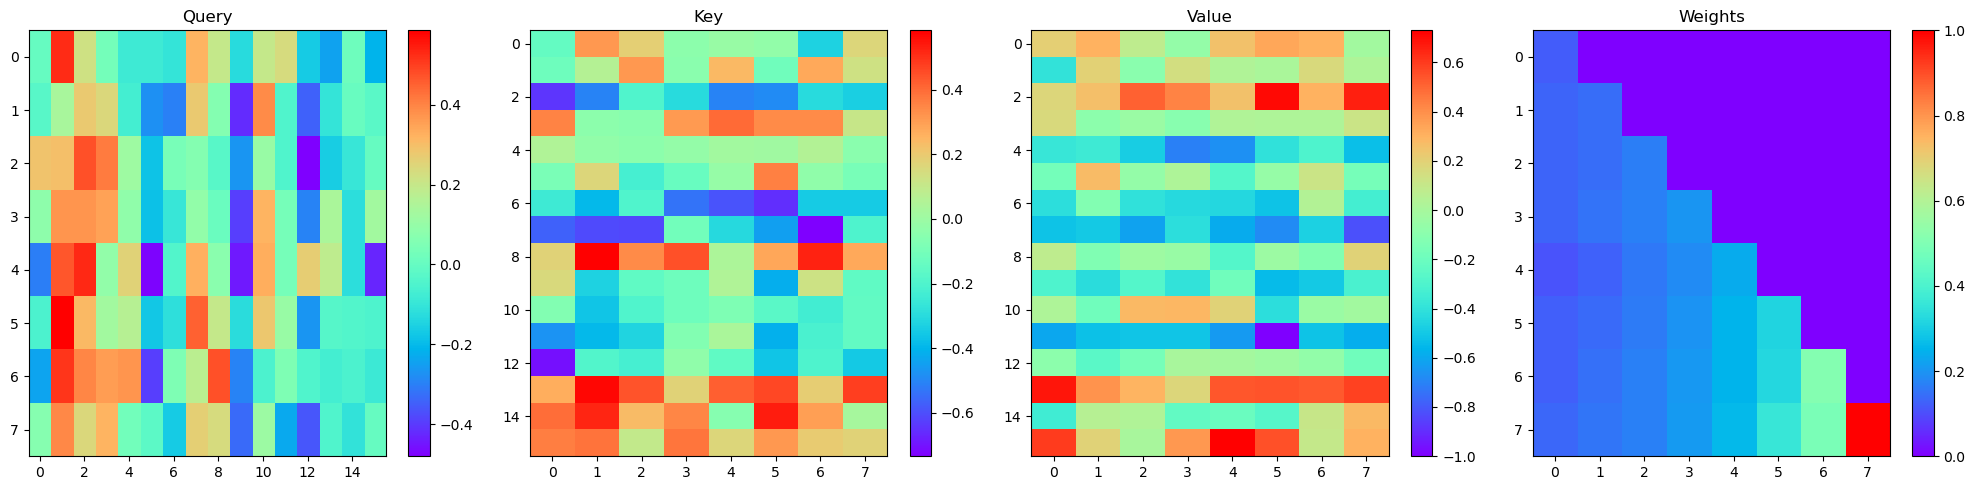

In [89]:
# lets plot query, key, value, and weights
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax = ax.flatten()

ax[0].set_title('Query')
cax0 = ax[0].imshow(q[0].detach().numpy(), aspect='auto', cmap='rainbow')
fig.colorbar(cax0, ax=ax[0])

ax[1].set_title('Key')
cax1 = ax[1].imshow(k[0].detach().numpy().T, aspect='auto', cmap='rainbow')
fig.colorbar(cax1, ax=ax[1])

ax[2].set_title('Value')
cax2 = ax[2].imshow(v[0].detach().numpy().T, aspect='auto', cmap='rainbow')
fig.colorbar(cax2, ax=ax[2])

ax[3].set_title('Weights')
cax3 = ax[3].imshow(wei[0].detach().numpy(), aspect='auto', cmap='rainbow')
fig.colorbar(cax3, ax=ax[3])

fig.tight_layout()


False